In [4]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from  tensorflow.keras import layers
from  tensorflow.keras.applications import DenseNet121,NASNetLarge, NASNetMobile
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization

# Set seeds to make the experiment more reproducible.

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


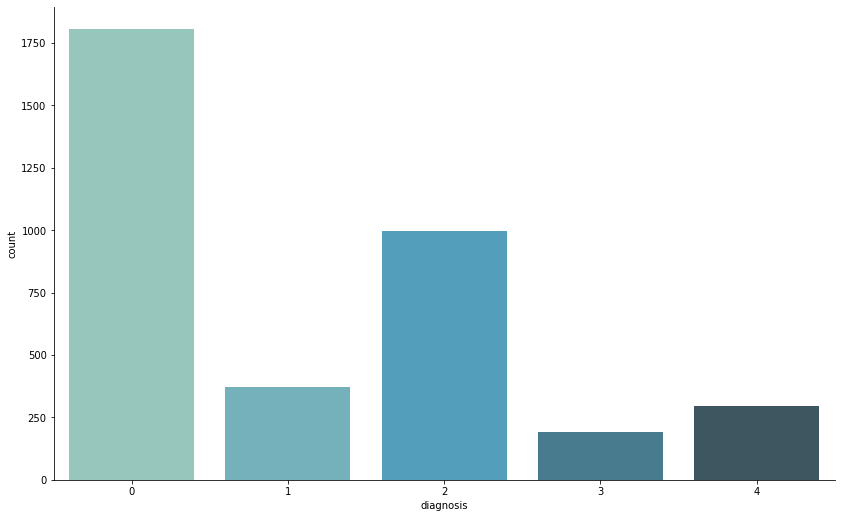

In [8]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")
sns.despine()
plt.show()

##### Legend
- 0 - No DR
- 1 - Mild
- 2 - Moderate
- 3 - Severe
- 4 - Proliferative DR 

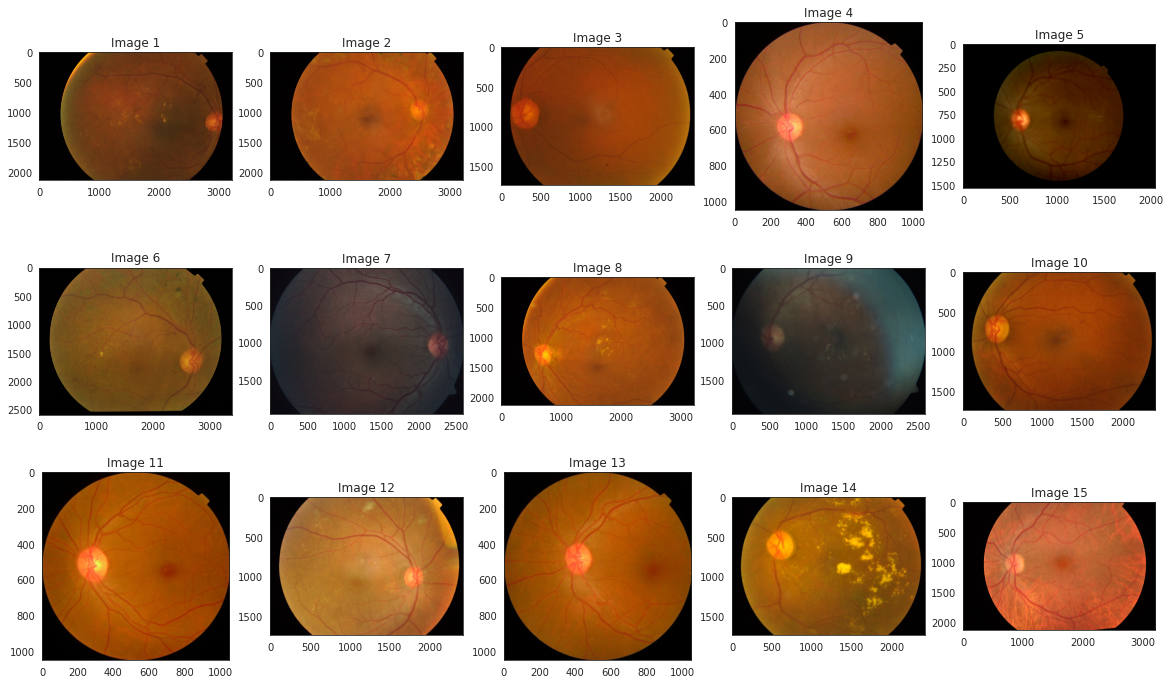

In [9]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train['id_code'][:15]:
    img = cv2.imread("/content/drive/MyDrive/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
plt.show()

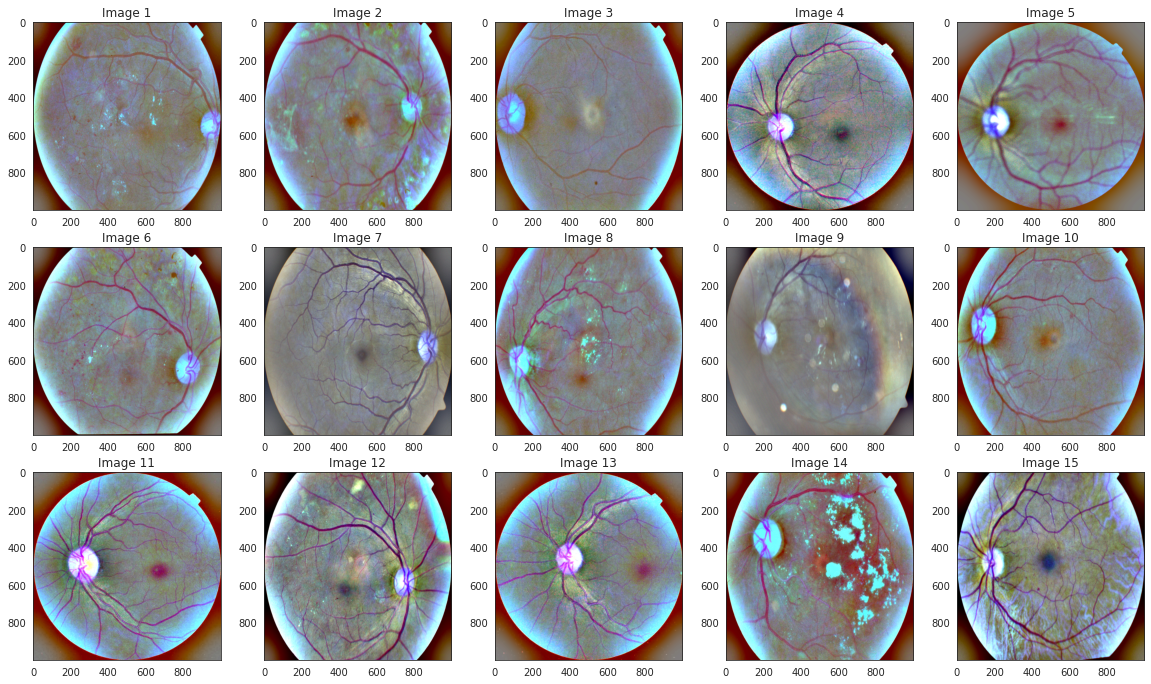

In [ ]:
#sns.set_style("white")
count = 1
IMG_SIZE = 1000
plt.figure(figsize=[20, 20])
for img_name in train['id_code'][:15]:
    #img = cv2.imread("/content/gdrive/MyDrive/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    img = load_ben_color("/content/drive/MyDrive/train_images/%s.png" % img_name)[...,[2,1,0]]
    cv2.imwrite ('/content/gdrive/MyDrive/Processed/%s.png' % img_name, img)
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
plt.show()

# Model parameters

In [10]:
# Model parameters
BATCH_SIZE = 8 #32 #8
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 512
WIDTH = 512
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [11]:
# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


## Data generator

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "/content/drive/MyDrive/test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


# Model

In [ ]:
#import tensorflow as tf
#from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, 
                                       include_top=False,
                                       input_tensor=input_tensor)
    base_model.load_weights('/content/drive/MyDrive/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',by_name=True,skip_mismatch=True)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [ ]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 128, 128, 64  256        ['conv2_block3_2_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 128, 128, 64  0          ['conv2_block3_2_bn[0][0]']      
 n)                             )                                                                 
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 128, 128, 25  16640       ['conv2_block3_2_relu[0][0]']    
                                6)                                                                
                                                                                                  
 conv2_blo

In [ ]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ization)                       )                                                                 
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 128, 128, 64  0          ['conv2_block3_1_bn[0][0]']      
 n)                             )                                                                 
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 128, 128, 64  36928       ['conv2_block3_1_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 128, 128, 64  256        ['conv2_block3_2_conv[0][0]']    
 ization)                       )                                                                 
          

# Train top layers

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/2
366/366 [==============================] - 1489s 4s/step - loss: 1.3304 - accuracy: 0.4949 - val_loss: 1.3368 - val_accuracy: 0.4615
Epoch 2/2
366/366 [==============================] - 673s 2s/step - loss: 1.3137 - accuracy: 0.4928 - val_loss: 1.3262 - val_accuracy: 0.4602


# Fine-tune the complete model

In [ ]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
366/366 [==============================] - 676s 2s/step - loss: 1.4336 - accuracy: 0.6146 - val_loss: 0.5864 - val_accuracy: 0.3022 - lr: 1.0000e-04
Epoch 2/20
366/366 [==============================] - 662s 2s/step - loss: 0.3454 - accuracy: 0.6708 - val_loss: 0.3619 - val_accuracy: 0.5810 - lr: 1.0000e-04
Epoch 3/20
366/366 [==============================] - 652s 2s/step - loss: 0.3128 - accuracy: 0.6893 - val_loss: 0.2740 - val_accuracy: 0.7019 - lr: 1.0000e-04
Epoch 4/20
366/366 [==============================] - 712s 2s/step - loss: 0.2964 - accuracy: 0.6992 - val_loss: 0.2757 - val_accuracy: 0.7019 - lr: 1.0000e-04
Epoch 5/20
366/366 [==============================] - 651s 2s/step - loss: 0.2874 - accuracy: 0.7088 - val_loss: 0.2811 - val_accuracy: 0.7074 - lr: 1.0000e-04
Epoch 6/20
366/366 [==============================] - 654s 2s/step - loss: 0.2830 - accuracy: 0.7067 - val_loss: 0.2678 - val_accuracy: 0.6992 - lr: 1.0000e-04
Epoch 7/20
366/366 [====================

In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
366/366 [==============================] - 629s 2s/step - loss: 0.2760 - accuracy: 0.7163 - val_loss: 0.3047 - val_accuracy: 0.6923 - lr: 5.0000e-05
Epoch 2/20
366/366 [==============================] - 635s 2s/step - loss: 0.2723 - accuracy: 0.7132 - val_loss: 0.3382 - val_accuracy: 0.6360 - lr: 5.0000e-05
Epoch 3/20
366/366 [==============================] - 635s 2s/step - loss: 0.2754 - accuracy: 0.7136 - val_loss: 0.3060 - val_accuracy: 0.6923 - lr: 5.0000e-05
Epoch 4/20
366/366 [==============================] - 640s 2s/step - loss: 0.2658 - accuracy: 0.7190 - val_loss: 0.2692 - val_accuracy: 0.7074 - lr: 5.0000e-05
Epoch 5/20
366/366 [==============================] - 638s 2s/step - loss: 0.2604 - accuracy: 0.7252 - val_loss: 0.3149 - val_accuracy: 0.6745 - lr: 5.0000e-05
Epoch 6/20
366/366 [==============================] - 632s 2s/step - loss: 0.2702 - accuracy: 0.7259 - val_loss: 0.3511 - val_accuracy: 0.6841 - lr: 5.0000e-05
Epoch 7/20
366/366 [====================

# Model loss graph 

In [ ]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['acc'] + history_finetunning['acc'], 
           'val_acc': history_warmup['val_acc'] + history_finetunning['val_acc']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Model Evaluation

In [ ]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train,
        directory = "../input/aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

## Confusion Matrix

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

## Quadratic Weighted Kappa

In [ ]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train['diagnosis'].astype('int'), weights='quadratic'))

# Apply model to test set and output predictions

In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

In [ ]:
filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)

## Predictions class distribution

In [ ]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()

In [ ]:
densenet = DenseNet121(
    weights='/content/drive/MyDrive/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [ ]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation = 'softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=20,
                    validation_data=valid_generator,
                    validation_steps = valid_generator.samples // BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
91/91 [==============================] - 231s 3s/step - loss: 0.2988 - accuracy: 0.8942 - val_loss: 0.4852 - val_accuracy: 0.8255
Epoch 2/20
91/91 [==============================] - 223s 2s/step - loss: 0.2815 - accuracy: 0.8942 - val_loss: 0.4882 - val_accuracy: 0.8214
Epoch 3/20
91/91 [==============================] - 223s 2s/step - loss: 0.2963 - accuracy: 0.8956 - val_loss: 0.4649 - val_accuracy: 0.8407
Epoch 4/20
91/91 [==============================] - 230s 3s/step - loss: 0.2962 - accuracy: 0.8878 - val_loss: 0.4700 - val_accuracy: 0.8297
Epoch 5/20
91/91 [==============================] - 225s 2s/step - loss: 0.2655 - accuracy: 0.9017 - val_loss: 0.4548 - val_accuracy: 0.8365
Epoch 6/20
91/91 [==============================] - 262s 3s/step - loss: 0.2715 - accuracy: 0.9038 - val_loss: 0.5072 - val_accuracy: 0.8379
Epoch 7/20
91/91 [==============================] - 226s 2s/step - loss: 0.2852 - accuracy: 0.8915 - val_loss: 0.5500 - val_accuracy: 0.8091
Epoch 8/20
91

Text(0, 0.5, '% Accuracy')

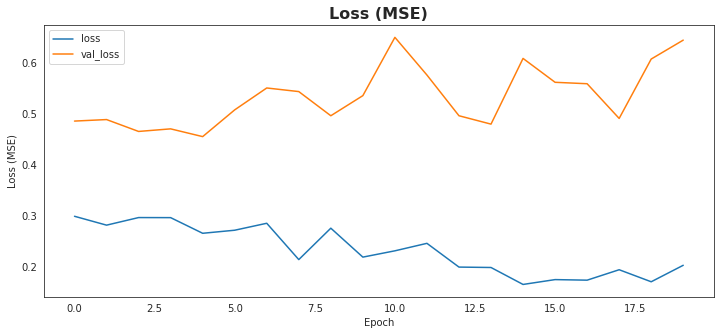

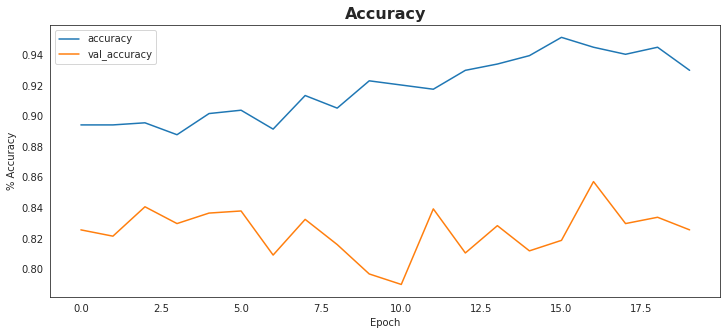

In [ ]:
history_df = pd.DataFrame(model.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy")

Text(0, 0.5, '% Accuracy')

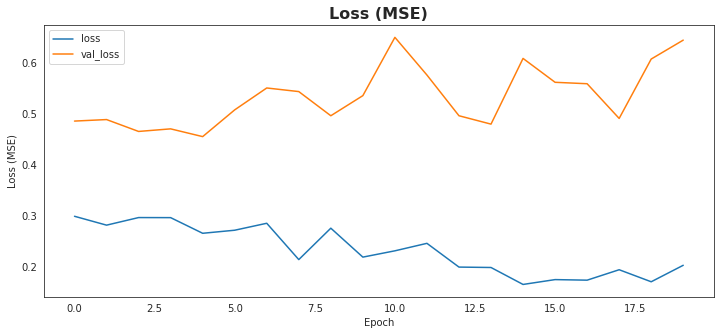

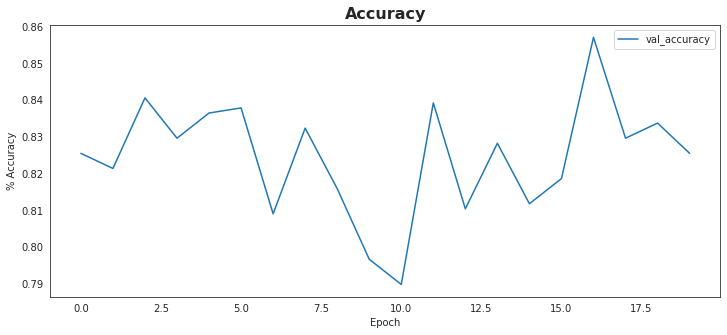

In [ ]:
history_df = pd.DataFrame(model.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy")

In [ ]:
#thats it add densenet in ppt with this graph and with 84% accuracy

In [ ]:
model.save('model.h5')

In [ ]:
HEIGHT=331
WIDTH=331
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "/content/drive/MyDrive/test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [ ]:
nas = NASNetLarge(
      include_top=False,
    weights='imagenet',
    input_shape=(331, 331, 3)
)

In [ ]:
def build_model():
    model = Sequential()
    model.add(nas)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation = 'softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 11, 11, 4032)      84916818  
                                                                 
 global_average_pooling2d_1   (None, 4032)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 4032)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 20165     
                                                                 
Total params: 84,936,983
Trainable params: 84,740,315
Non-trainable params: 196,668
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=5,
                    validation_data=valid_generator,
                    validation_steps = valid_generator.samples // BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/5
366/366 [==============================] - 1556s 4s/step - loss: 0.6559 - accuracy: 0.7598 - val_loss: 0.8442 - val_accuracy: 0.7418
Epoch 2/5
366/366 [==============================] - 570s 2s/step - loss: 0.4526 - accuracy: 0.8374 - val_loss: 0.8876 - val_accuracy: 0.7404
Epoch 3/5
366/366 [==============================] - 573s 2s/step - loss: 0.3164 - accuracy: 0.8809 - val_loss: 0.9638 - val_accuracy: 0.7706
Epoch 4/5
366/366 [==============================] - 572s 2s/step - loss: 0.2109 - accuracy: 0.9281 - val_loss: 1.1631 - val_accuracy: 0.7418
Epoch 5/5
366/366 [==============================] - 570s 2s/step - loss: 0.1504 - accuracy: 0.9483 - val_loss: 1.1247 - val_accuracy: 0.7761


In [ ]:
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=10,
                    validation_data=valid_generator,
                    validation_steps = valid_generator.samples // BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
366/366 [==============================] - 614s 2s/step - loss: 0.7263 - accuracy: 0.7402 - val_loss: 0.9413 - val_accuracy: 0.6731
Epoch 2/10
366/366 [==============================] - 573s 2s/step - loss: 0.4646 - accuracy: 0.8231 - val_loss: 0.8803 - val_accuracy: 0.7335
Epoch 3/10
366/366 [==============================] - 572s 2s/step - loss: 0.3453 - accuracy: 0.8730 - val_loss: 1.0213 - val_accuracy: 0.7473
Epoch 4/10
366/366 [==============================] - 573s 2s/step - loss: 0.2283 - accuracy: 0.9206 - val_loss: 1.1007 - val_accuracy: 0.7473
Epoch 5/10
366/366 [==============================] - 572s 2s/step - loss: 0.1575 - accuracy: 0.9439 - val_loss: 1.2236 - val_accuracy: 0.7871
Epoch 6/10
366/366 [==============================] - 573s 2s/step - loss: 0.1137 - accuracy: 0.9641 - val_loss: 1.3484 - val_accuracy: 0.7816
Epoch 7/10
366/366 [==============================] - 575s 2s/step - loss: 0.0959 - accuracy: 0.9644 - val_loss: 1.7783 - val_accuracy: 0.7170

Text(0, 0.5, '% Accuracy')

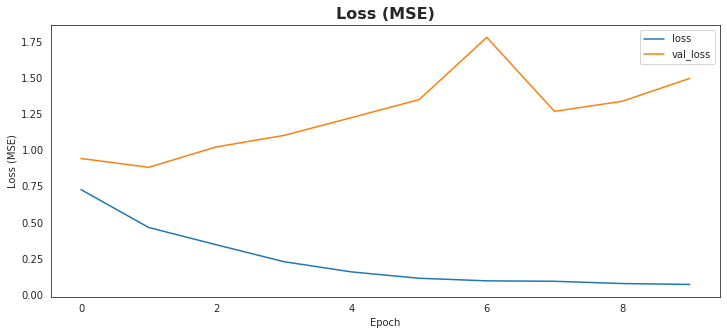

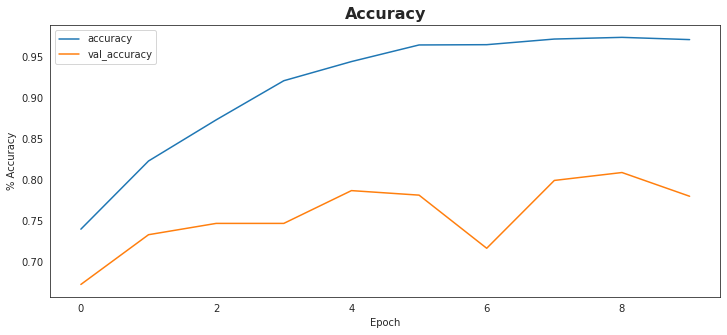

In [ ]:
history_df = pd.DataFrame(model.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy")

In [ ]:
model.save('model21.h5')

In [12]:
HEIGHT=224
WIDTH=224
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "/content/drive/MyDrive/test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [13]:
nas = NASNetMobile(
      include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

20004864/19993432 [==============================] - 0s 0us/step


In [14]:
def build_model():
    model = Sequential()
    model.add(nas)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation = 'softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    return model

In [15]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 global_average_pooling2d (G  (None, 1056)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1056)              0         
                                                                 
 dense (Dense)               (None, 5)                 5285      
                                                                 
Total params: 4,275,001
Trainable params: 4,238,263
Non-trainable params: 36,738
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=10,
                    validation_data=valid_generator,
                    validation_steps = valid_generator.samples // BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
366/366 [==============================] - 3919s 11s/step - loss: 0.9677 - accuracy: 0.6407 - val_loss: 1.0187 - val_accuracy: 0.6525
Epoch 2/10
366/366 [==============================] - 435s 1s/step - loss: 0.6880 - accuracy: 0.7502 - val_loss: 0.8878 - val_accuracy: 0.6635
Epoch 3/10
366/366 [==============================] - 435s 1s/step - loss: 0.6041 - accuracy: 0.7864 - val_loss: 0.8245 - val_accuracy: 0.7033
Epoch 4/10
366/366 [==============================] - 435s 1s/step - loss: 0.5378 - accuracy: 0.8039 - val_loss: 0.8037 - val_accuracy: 0.7198
Epoch 5/10
366/366 [==============================] - 435s 1s/step - loss: 0.4711 - accuracy: 0.8306 - val_loss: 0.8550 - val_accuracy: 0.7088
Epoch 6/10
366/366 [==============================] - 436s 1s/step - loss: 0.4161 - accuracy: 0.8453 - val_loss: 0.7339 - val_accuracy: 0.7555
Epoch 7/10
366/366 [==============================] - 435s 1s/step - loss: 0.3667 - accuracy: 0.8700 - val_loss: 0.8798 - val_accuracy: 0.74

Text(0, 0.5, '% Accuracy')

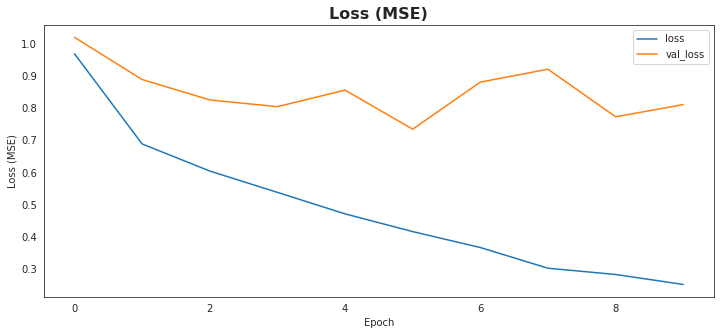

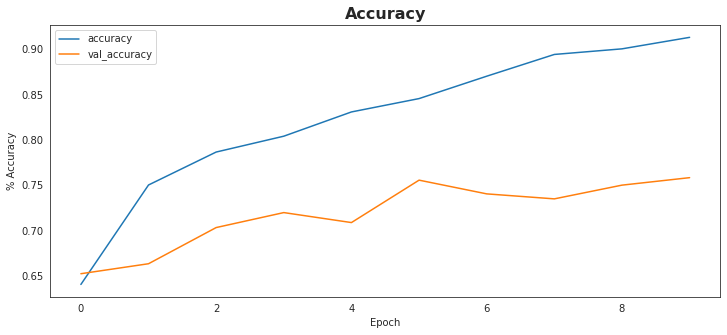

In [17]:
history_df = pd.DataFrame(model.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['accuracy', 'val_accuracy']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy")

In [18]:
model.save('model3.h5')

In [ ]:
def build_model():
    model = Sequential()
    model.add(nas)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation = 'softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    return model

In [ ]:
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=10,
                    validation_data=valid_generator,
                    validation_steps = valid_generator.samples // BATCH_SIZE)

In [ ]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation = 'softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    return model

In [ ]:
IMG_WIDTH = 456
IMG_HEIGHT = 456
CHANNELS = 3

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)



test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "/content/drive/MyDrive/test_images/",
        x_col="id_code",
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


In [ ]:
!pip install  efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.2 MB/s 


In [ ]:
import efficientnet.tfkeras as efn

In [ ]:
enet = efn.EfficientNetB5(
           include_top=False,
        weights='imagenet',
       input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS)
    )

115523584/115515256 [==============================] - 1s 0us/step


In [ ]:
for i, layer in enumerate(enet.layers):
    if "batch_normalization" in layer.name:
        enet.layers[i] = GroupNormalization(groups=32, axis=-1, epsilon=0.00001)

In [ ]:
enet.summary()

In [ ]:
from keras.activations import elu

In [ ]:
def build_model():

    model = Sequential()
    model.add(enet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation=elu))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functional  (None, 15, 15, 2048)     28513520  
 )                                                               
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 28,523,765
Trainable params: 28,351,029
Non-trainable params: 172,736
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/2


InvalidArgumentError: ignored

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.utils import get_custom_objects

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform

In [ ]:
!pip install tensorflow-addons==0.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 19.8 MB/s 


In [ ]:
from typeguard import typechecked

from tensorflow_addons.utils import types

In [ ]:
!pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 31.0 MB/s 
     |████████████████████████████████| 145 kB 74.1 MB/s 
     |████████████████████████████████| 237 kB 73.0 MB/s 
     |████████████████████████████████| 51 kB 7.6 MB/s 
     |████████████████████████████████| 85 kB 5.1 MB/s 


In [ ]:
from flax.linen.module import Module
from jax import lax
from jax.nn import initializers
import jax.numpy as jnp

In [ ]:
class EfficientConv2DKernelInitializer(Initializer):
    """Initialization for convolutional kernels.
    The main difference with tf.variance_scaling_initializer is that
    tf.variance_scaling_initializer uses a truncated normal with an uncorrected
    standard deviation, whereas here we use a normal distribution. Similarly,
    tf.contrib.layers.variance_scaling_initializer uses a truncated normal with
    a corrected standard deviation.
    Args:
      shape: shape of variable
      dtype: dtype of variable
      partition_info: unused
    Returns:
      an initialization for the variable
    """

    def __call__(self, shape, dtype=float, **kwargs):
        kernel_height, kernel_width, _, out_filters = shape
        fan_out = int(kernel_height * kernel_width * out_filters)
        return tf.random_normal(
            shape, mean=0.0, stddev=np.sqrt(2.0 / fan_out), dtype=dtype
        )


class EfficientDenseKernelInitializer(Initializer):
    """Initialization for dense kernels.
    This initialization is equal to
      tf.variance_scaling_initializer(scale=1.0/3.0, mode='fan_out',
                                      distribution='uniform').
    It is written out explicitly here for clarity.
    Args:
      shape: shape of variable
      dtype: dtype of variable
    Returns:
      an initialization for the variable
    """

    def __call__(self, shape, dtype=float, **kwargs):
        """Initialization for dense kernels.
        This initialization is equal to
          tf.variance_scaling_initializer(scale=1.0/3.0, mode='fan_out',
                                          distribution='uniform').
        It is written out explicitly here for clarity.
        Args:
          shape: shape of variable
          dtype: dtype of variable
        Returns:
          an initialization for the variable
        """
        init_range = 1.0 / np.sqrt(shape[1])
        return tf.random_uniform(shape, -init_range, init_range, dtype=dtype)


class GroupNorm(Module):
  """Group normalization (arxiv.org/abs/1803.08494).

    This op is similar to batch normalization, but statistics are shared across
    equally-sized groups of channels and not shared across batch dimension.
    Thus, group normalization does not depend on the batch composition and does
    not require maintaining internal state for storing statistics.
    The user should either specify the total number of channel groups or the
    number of channels per group.

    Attributes:
      num_groups: the total number of channel groups. The default value of 32 is
        proposed by the original group normalization paper.
      group_size: the number of channels in a group.
      epsilon: A small float added to variance to avoid dividing by zero.
      dtype: the dtype of the result (default: infer from input and params).
      param_dtype: the dtype passed to parameter initializers (default: float32).
      use_bias:  If True, bias (beta) is added.
      use_scale: If True, multiply by scale (gamma). When the next layer is
        linear (also e.g. nn.relu), this can be disabled since the scaling will
        be done by the next layer.
      bias_init: Initializer for bias, by default, zero.
      scale_init: Initializer for scale, by default, one.
      axis_name: the axis name used to combine batch statistics from multiple
        devices. See `jax.pmap` for a description of axis names (default: None).
        This is only needed if the model is subdivided across devices, i.e. the
        array being normalized is sharded across devices within a pmap.
      axis_index_groups: groups of axis indices within that named axis
        representing subsets of devices to reduce over (default: None). For
        example, `[[0, 1], [2, 3]]` would independently batch-normalize over
        the examples on the first two and last two devices. See `jax.lax.psum`
        for more details.
  """
  num_groups = 32
  group_size  = None
  epsilon: float = 1e-6
  dtype = None
  param_dtype = jnp.float32
  use_bias: bool = True
  use_scale: bool = True
  axis_name = None
  axis_index_groups= None

  def __call__(self, x):
    """Applies group normalization to the input (arxiv.org/abs/1803.08494).

    Args:
      x: the input of shape N...C, where N is a batch dimension and C is a
        channels dimensions. `...` represents an arbitrary number of extra
        dimensions that are used to accumulate statistics over.

    Returns:
      Normalized inputs (the same shape as inputs).
    """
    reduction_axes = list(range(1, x.ndim - 1)) + [-1]
    feature_axes = (-1,)

    if ((self.num_groups is None and self.group_size is None) or
        (self.num_groups is not None and self.group_size is not None)):
      raise ValueError('Either `num_groups` or `group_size` should be '
                       'specified. If `group_size` is to be specified, '
                       'pass `num_groups=None` as argument to override '
                       'the default `num_groups` value of 32.')

    channels = x.shape[-1]
    if self.group_size is not None:
      if channels % self.group_size != 0:
        raise ValueError('Number of channels ({}) is not multiple of the '
                         'group size ({}).'.format(channels, self.group_size))
      num_groups = channels // self.group_size
    else:
      num_groups = self.num_groups
      assert isinstance(num_groups, int)

    if num_groups <= 0 or channels % num_groups != 0:
      raise ValueError('Number of groups ({}) does not divide the number'
                       ' of channels ({}).'.format(num_groups, channels))

    group_size = x.shape[-1] // num_groups
    group_shape = x.shape[:-1] + (num_groups, group_size)

    def broadcast_stat(stat):
      stat = jnp.broadcast_to(stat[..., None],
                              (x.shape[0], num_groups, group_size))
      return stat.reshape((x.shape[0], num_groups * group_size))

    mean, var = _compute_stats(
        x.reshape(group_shape), reduction_axes, self.dtype, self.axis_name,
        self.axis_index_groups)
    mean = broadcast_stat(mean)
    var = broadcast_stat(var)

    return _normalize(
        self, x, mean, var, reduction_axes[:-1], feature_axes,
        self.dtype, self.param_dtype, self.epsilon,
        self.use_bias, self.use_scale,
        self.bias_init, self.scale_init)


conv_kernel_initializer = EfficientConv2DKernelInitializer()
dense_kernel_initializer = EfficientDenseKernelInitializer()


get_custom_objects().update(
    {
        "EfficientDenseKernelInitializer": EfficientDenseKernelInitializer,
        "EfficientConv2DKernelInitializer": EfficientConv2DKernelInitializer,
        "GroupNormalization": GroupNormalization
    }
)


In [ ]:
keras_model = tf.keras.models.load_model('/content/drive/MyDrive/model.h5', compile=False)
keras_model2 = tf.keras.models.load_model('/content/drive/MyDrive/effnet_modelB5.h5', compile=False)

TypeError: ignored

In [ ]:
models = [keras_model, keras_model2]
model_input = tf.keras.Input(shape=(125, 125, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)